In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.metrics import accuracy_score



/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load data and ensure there are no na in dataset
train = pd.read_csv('./training.csv')

train.isna().any()

text     False
label    False
dtype: bool

In [3]:
#Perform oversampling and undersampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print("Before undersampling:", Counter(train['label']))

class_counts = Counter(train['label'])

# Set the target number of samples per class
target_samples = 3000

# Determine classes needing oversampling and undersampling
classes_to_resample = {cls: target_samples for cls, count in class_counts.items() if count < target_samples}
classes_to_keep = {cls: target_samples for cls, count in class_counts.items() if count >= target_samples}
print('Class to OverSample: ', classes_to_resample)
print("Class to UnderSample: ", classes_to_keep)
# Oversample minority classes
oversampler = RandomOverSampler(sampling_strategy=classes_to_resample)

# Undersample majority classes
undersampler = RandomUnderSampler(sampling_strategy=classes_to_keep)


train_text_resampled, train_labels_resampled = oversampler.fit_resample(np.array(train['text']).reshape(-1,1), train['label'])

print('After Oversample:' , Counter(train_labels_resampled))

train_text_resampled, train_labels_resampled = undersampler.fit_resample(train_text_resampled, train_labels_resampled)

# Check the class distribution after resampling
print('After Undersample:', Counter(train_labels_resampled))

Before undersampling: Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})
Class to OverSample:  {3: 3000, 2: 3000, 5: 3000, 4: 3000}
Class to UnderSample:  {0: 3000, 1: 3000}
After Oversample: Counter({1: 5362, 0: 4666, 3: 3000, 2: 3000, 5: 3000, 4: 3000})
After Undersample: Counter({0: 3000, 1: 3000, 2: 3000, 3: 3000, 4: 3000, 5: 3000})


In [4]:
#split data to train, validation, and test sets
from sklearn.model_selection import train_test_split
train_labels_resampled = np.array(train_labels_resampled)
X_train, X_temp, y_train, y_temp = train_test_split(train_text_resampled,train_labels_resampled,test_size=0.3,random_state=42)
X_val, X_test, y_val,y_test =  train_test_split(X_temp,y_temp,test_size=0.5, random_state=42)

In [5]:
#load tokenizer from transformers library
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [6]:
#setup function for tokenize the data
def tokenize(data):
  data = [sentence[0] for sentence in data]
  tokenized_data = tokenizer.batch_encode_plus(data,
                                             max_length=50,
                                            padding=True,
                                             truncation=True,
                                             return_tensors='pt')
  return tokenized_data


#tokenize data for train, val, test set
tokenized_data_train = tokenize(X_train)
tokenized_data_val = tokenize(X_val)
tokenized_data_test =  tokenize(X_test)

In [7]:
print(tokenized_data_train)

{'input_ids': tensor([[  101,  1045,  2371,  ...,     0,     0,     0],
        [  101, 10047,  5121,  ...,     0,     0,     0],
        [  101,  1045,  2079,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2001,  ...,     0,     0,     0],
        [  101,  1045,  2196,  ...,     0,     0,     0],
        [  101, 10047,  2025,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [8]:
#Convert to desired format
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenized_data_train),
    y_train
)).shuffle(len(train['text'])).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenized_data_val),
    y_val
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenized_data_test),
    y_test
)).batch(32)

In [9]:
#load model from transformer
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)

model.layers[0].trainable = False

print(model.summary())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66958086 (255.42 MB)
Trainable params: 595206 (2.27 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________
None


In [10]:
# Define optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-5)

# Compile the model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Fine-tuning
history = model.fit(train_dataset,
                    batch_size = 20,
                    epochs=80,
                    validation_data=val_dataset,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.01, patience=5)]
                    )


Epoch 1/80
394/394 [==============================] - 204s 512ms/step - loss: 1.7667 - accuracy: 0.2544 - val_loss: 1.7315 - val_accuracy: 0.3600
Epoch 2/80
394/394 [==============================] - 201s 512ms/step - loss: 1.7011 - accuracy: 0.3577 - val_loss: 1.6556 - val_accuracy: 0.4104
Epoch 3/80
394/394 [==============================] - 203s 514ms/step - loss: 1.6309 - accuracy: 0.3976 - val_loss: 1.5882 - val_accuracy: 0.4267
Epoch 4/80
394/394 [==============================] - 205s 520ms/step - loss: 1.5704 - accuracy: 0.4127 - val_loss: 1.5336 - val_accuracy: 0.4367
Epoch 5/80
394/394 [==============================] - 211s 536ms/step - loss: 1.5265 - accuracy: 0.4303 - val_loss: 1.4932 - val_accuracy: 0.4456
Epoch 6/80
394/394 [==============================] - 209s 531ms/step - loss: 1.4884 - accuracy: 0.4438 - val_loss: 1.4607 - val_accuracy: 0.4496
Epoch 7/80
394/394 [==============================] - 202s 512ms/step - loss: 1.4593 - accuracy: 0.4505 - val_loss: 1.4304 -

In [11]:
#Evaluation
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss} Test Accuracy: {test_accuracy}')

85/85 [==============================] - 34s 393ms/step - loss: 1.1219 - accuracy: 0.5811
Test Loss: 1.121917724609375 Test Accuracy: 0.5811111330986023


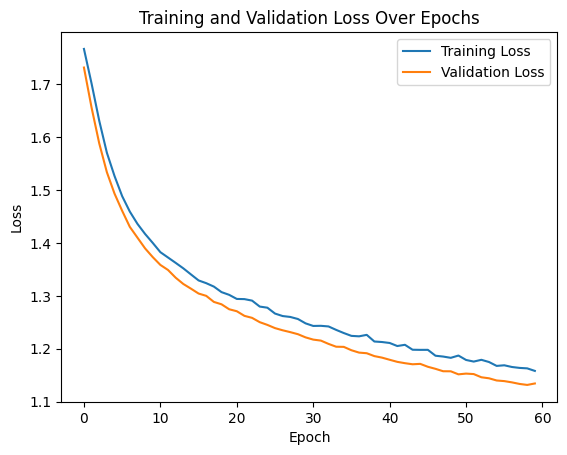

In [12]:
import matplotlib.pyplot as plt

loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()